In [1]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from imblearn.under_sampling import RandomUnderSampler
import itertools
from collections import Counter
import shutil
import csv
import keras_tuner as kt
from tensorflow import keras


2023-12-03 13:18:15.412151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!find . -name ".DS_Store" -print -delete


./MRNet-v1.0/.DS_Store
./MRNet-v1.0/train_4x4_cropped/.DS_Store
./my_dir/intro_to_kt/.DS_Store
./my_dir/intro_to_kt2/.DS_Store


In [4]:
class_names = ['no meniscus tear', 'meniscus tear']
nClasses = len(class_names)
print("Num classes:", nClasses, "classes (0 1):", class_names)


################# folder structure to generate datasets############
# #training images
# data_dir = 'MRNet-v1.0/axial-sagittal-coronal-grid'  

# train_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.15,
#   subset="training",
#   seed=123,
#   image_size = (512,512))


# val_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.15,
#   subset="validation",
#   seed=123,
#   image_size = (512,512))

#######################csv with labels#####################
#training images
train_folder_path_images = 'MRNet-v1.0/train_4x4_cropped/rgb_stacks_4x4_cropped'  # Update this with the path to your folder containing .npy files
train_images = sorted(os.listdir(train_folder_path_images))
train_nImages = len(train_images)
print("Num Images train:",train_nImages)
print("train_images[0]:",train_images[0])

#####training labels#####      
temp,train_labels = np.loadtxt("MRNet-v1.0/train-meniscus.csv",
                 delimiter=",", dtype=int, unpack=True) #need to unpack when using the given csv's with 2 columns
print(train_labels)
train_labels = list(train_labels)


#ensure the number of labels matches the number of imag
train_labelsCropped = train_labels[:train_nImages]
print("Num labels train:", len(train_labelsCropped))


# ################ balanced dataset#################
# num_classes = len(np.unique(train_labelsCropped))
# print(num_classes)
# # Create a Dataset from features and labels
# train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labelsCropped))

# # Separate data based on classes
# class_datasets = []
# for i in range(num_classes):
#     class_indices = np.array((np.array(train_labelsCropped) > (i - 0.5)) & (np.array(train_labelsCropped) < (i + 0.5)).astype(int))
#     # print("class indices:",class_indices)
#     class_features = np.array(train_images)[class_indices]
#     class_labels = np.array(train_labelsCropped)[class_indices]

#     class_dataset = tf.data.Dataset.from_tensor_slices((class_features, class_labels))
#     class_datasets.append(class_dataset)

# # Combine class datasets
# balanced_dataset = tf.data.Dataset.sample_from_datasets(class_datasets).shuffle(1000)

# # Batch the balanced dataset
# batch_size = 32
# train_ds = balanced_dataset.batch(batch_size)
# ################ balanced dataset#################

print("============================")

#####validation images#####
valid_folder_path_images = 'MRNet-v1.0/valid_4x4_cropped/rgb_stacks_4x4_cropped'  # Update this with the path to your folder containing .npy files
valid_images = sorted(os.listdir(valid_folder_path_images))
# valid_images = sorted([f for f in os.listdir(valid_folder_path_images) if f.lower().endswith('.jpeg')])
valid_nImages = len(valid_images)
print("Num Images valid:",valid_nImages)
print("valid_images[0]:",valid_images[0])

#validation labels   
temp,valid_labels = np.loadtxt("MRNet-v1.0/valid-meniscus.csv",
                 delimiter=",", dtype=int, unpack=True) #need to unpack when using the given csv's with 2 columns
valid_labels = list(valid_labels)
#ensure the number of labels matches the number of imag
valid_labelsCropped = valid_labels[:valid_nImages]
print("Num labels valid:", len(valid_labelsCropped))



# ################ balanced dataset#################
# num_classes = len(np.unique(train_labelsCropped))
# # Create a Dataset from features and labels
# val_ds = tf.data.Dataset.from_tensor_slices((valid_images,valid_labelsCropped))

# # Separate data based on classes
# class_datasets = []
# for i in range(num_classes):
#     class_indices = (np.array(train_labelsCropped) > (i - 0.5)) & (np.array(train_labelsCropped) < (i + 0.5)).astype(int)
#     class_features = np.array(valid_images)[class_indices]
#     class_labels = np.array(valid_labelsCropped)[class_indices]

#     class_dataset = tf.data.Dataset.from_tensor_slices((class_features, class_labels))
#     class_datasets.append(class_dataset)

# # Combine class datasets
# balanced_dataset = tf.data.Dataset.sample_from_datasets(class_datasets).shuffle(1000)

# # Batch the balanced dataset
# batch_size = 32
# val_ds = balanced_dataset.batch(batch_size)
# ################ balanced dataset#################


labels_counter = Counter(train_labelsCropped)
print("train labels", labels_counter)
labels_counter = Counter(valid_labelsCropped)
print("valid labels", labels_counter)

Num classes: 2 classes (0 1): ['no meniscus tear', 'meniscus tear']
Num Images train: 1130
train_images[0]: rgbAxes_0000.jpeg
[0 1 0 ... 0 0 0]
Num labels train: 1130
Num Images valid: 120
valid_images[0]: rgbAxes_1130.jpeg
Num labels valid: 120
train labels Counter({0: 733, 1: 397})
valid labels Counter({0: 68, 1: 52})


<font size=5> Balance Datasets (Train)

In [5]:

# Assuming labels contain the original labels as ints and images contain the list of image filenames
labels_counter = Counter(train_labelsCropped)
print("train", labels_counter)


# Determine the count of the least common label
min_label_count = min(labels_counter.values())
# print(min_label_count)

balanced_labels = []
balanced_images = []
for label, image in zip(train_labelsCropped, train_images):
    # print(image, label)
    bal_labels_counter = Counter(balanced_labels)
    if bal_labels_counter[label] <= min_label_count:

        balanced_labels.append(label)
        balanced_images.append(image)
        
#save balanced dataset images and labels to folder:
folder_path = 'MRNet-v1.0/train_4x4_cropped'

#Step 2 get current path and create new folder to save data in current path
balanced_images_path = os.path.join(os.getcwd(), folder_path, 'balanced_meniscus_class_rgb_stacks')

if not os.path.exists(balanced_images_path): 
    os.makedirs(balanced_images_path)
    


# Assuming the files are in the current directory, copy balanced images to new folder
for file_name in balanced_images:
    # Replace 'path_to_your_files_folder' with the path to your original files
    file_path = os.path.join(train_folder_path_images, file_name)
    shutil.copy(file_path, balanced_images_path)    
    
# Name for the CSV file
csv_name = 'balanced_labels_meniscus_train.csv'
if not os.path.exists(csv_name): 
    np.savetxt(csv_name, balanced_labels, delimiter=",", fmt = '%d')
print("Saved csv:", csv_name, "in path", os.getcwd())


print("\n\n this path will be the path to the balanced images", balanced_images_path)
   

train Counter({0: 733, 1: 397})
Saved csv: balanced_labels_meniscus_train.csv in path /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification


 this path will be the path to the balanced images /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/MRNet-v1.0/train_4x4_cropped/balanced_meniscus_class_rgb_stacks


<font size=5> Balance Datasets (Valid)

In [6]:
# Assuming labels contain the original labels as ints and images contain the list of image filenames
labels_counter = Counter(valid_labelsCropped)
print("valid", labels_counter)


# Determine the count of the least common label
min_label_count = min(labels_counter.values())
# print(min_label_count)

balanced_labels = []
balanced_images = []
for label, image in zip(valid_labelsCropped, valid_images):
    # print(image, label)
    bal_labels_counter = Counter(balanced_labels)
    if bal_labels_counter[label] <= min_label_count:

        balanced_labels.append(label)
        balanced_images.append(image)
        
#save balanced dataset images and labels to folder:
folder_path = 'MRNet-v1.0/valid_4x4_cropped'

#Step 2 get current path and create new folder to save data in current path
balanced_images_path = os.path.join(os.getcwd(), folder_path, 'balanced_meniscus_class_rgb_stacks')

if not os.path.exists(balanced_images_path): 
    os.makedirs(balanced_images_path)
    


# Assuming the files are in the current directory, copy balanced images to new folder
for file_name in balanced_images:
    # Replace 'path_to_your_files_folder' with the path to your original files
    file_path = os.path.join(valid_folder_path_images, file_name)
    shutil.copy(file_path, balanced_images_path)    
    
# Name for the CSV file
csv_name = 'balanced_labels_meniscus_valid.csv'
if not os.path.exists(csv_name): 
    np.savetxt(csv_name, balanced_labels, delimiter=",", fmt = '%d')
print("Saved csv:", csv_name, "in path", os.getcwd())


print("\n\n this path will be the path to the balanced images", balanced_images_path)

valid Counter({0: 68, 1: 52})
Saved csv: balanced_labels_meniscus_valid.csv in path /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification


 this path will be the path to the balanced images /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/MRNet-v1.0/valid_4x4_cropped/balanced_meniscus_class_rgb_stacks


<font size=5> Load balanced data

In [3]:
#training
train_folder_path_images = 'MRNet-v1.0/train_4x4_cropped/balanced_meniscus_class_rgb_stacks'
train_images = sorted(os.listdir(train_folder_path_images))
train_nImages = len(train_images)
print("Num Images train:",train_nImages)

train_labels = np.loadtxt("MRNet-v1.0/train_4x4_cropped/balanced_labels_meniscus_train.csv",
                 delimiter=",", dtype=int)
train_labels = list(train_labels)
train_labelsCropped = train_labels[:train_nImages]
print("Num labels train:", len(train_labelsCropped))
labels_counter = Counter(train_labelsCropped)
print("train", labels_counter)


#validation
valid_folder_path_images = 'MRNet-v1.0/valid_4x4_cropped/balanced_meniscus_class_rgb_stacks'
valid_labels = np.loadtxt("MRNet-v1.0/valid_4x4_cropped/balanced_labels_meniscus_valid.csv",
                 delimiter=",", dtype=int)
valid_images = sorted(os.listdir(valid_folder_path_images))
valid_nImages = len(valid_images)
print("Num Images valid:",valid_nImages)


valid_labels = list(valid_labels)
valid_labelsCropped = valid_labels[:valid_nImages]
print("Num labels valid:", len(valid_labelsCropped))
labels_counter = Counter(valid_labelsCropped)
print("valid", labels_counter)

Num Images train: 795
Num labels train: 795
train Counter({0: 398, 1: 397})
Num Images valid: 105
Num labels valid: 105
valid Counter({0: 53, 1: 52})


<font size=5> Generate datasets

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_folder_path_images, 
                                                       shuffle=True, 
                                                       labels=train_labelsCropped, 
                                                       image_size=(512,512), 
                                                       color_mode='rgb',
                                                       label_mode="int")


val_ds = tf.keras.utils.image_dataset_from_directory(valid_folder_path_images, 
                                                       shuffle=True, 
                                                       labels=valid_labelsCropped, 
                                                       image_size=(512,512),
                                                       color_mode='rgb',
                                                       label_mode="int")

Found 795 files belonging to 2 classes.
Found 105 files belonging to 2 classes.


In [7]:
# class_names = train_ds.class_names
# print("Class names", class_names) #class names are organized in alphabetical order


#normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 


#extract image dimensions and print some information including example labels
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]

print("\nImage batch shape",image_batch.shape)
print("Labels:",labels_batch)
img_height = len(first_image[0])
img_width = len(first_image[1])


#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

images = []
for im, lab in iter(val_ds):
    images.append(im)
    
print(len(images))


Image batch shape (32, 512, 512, 3)
Labels: tf.Tensor([1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0], shape=(32,), dtype=int32)
0.0 1.0
4


<font size=5> Determine best hyperparameters (#nodes in first dense layer and learning rate)

In [ ]:
from tensorflow.keras.regularizers import l2
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(512,512,3)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(512, 512, 3), kernel_regularizer=l2(0.01)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#     model.add(keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#     model.add(keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(0.01)))  # Added another Conv2D layer
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    
    
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', #thing we want to optimize
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2') #, overwrite=True


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, epochs=50,validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 20 Complete [00h 02m 15s]
val_accuracy: 0.5809524059295654

Best val_accuracy So Far: 0.7047619223594666
Total elapsed time: 00h 59m 57s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
512               |320               |units
0.001             |0.001             |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round



<font size=5> Determine best hyperparameters (#epochs)

In [28]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
25/25 [==============================] - 81s 3s/step - loss: 2.1741 - accuracy: 0.4792 - val_loss: 1.9706 - val_accuracy: 0.5048
Epoch 2/50
25/25 [==============================] - 73s 3s/step - loss: 1.6807 - accuracy: 0.5006 - val_loss: 1.3367 - val_accuracy: 0.5048
Epoch 3/50
25/25 [==============================] - 67s 2s/step - loss: 1.0890 - accuracy: 0.5006 - val_loss: 0.8907 - val_accuracy: 0.5048
Epoch 4/50
25/25 [==============================] - 72s 3s/step - loss: 0.8169 - accuracy: 0.5006 - val_loss: 0.7648 - val_accuracy: 0.5048
Epoch 5/50
25/25 [==============================] - 68s 3s/step - loss: 0.7458 - accuracy: 0.5019 - val_loss: 0.7314 - val_accuracy: 0.4952
Epoch 6/50
25/25 [==============================] - 69s 3s/step - loss: 0.7246 - accuracy: 0.4931 - val_loss: 0.7179 - val_accuracy: 0.5048
Epoch 7/50
25/25 [==============================] - 72s 3s/step - loss: 0.7170 - accuracy: 0.4969 - val_loss: 0.7115 - val_accuracy: 0.4952
Epoch 8/50
25/25 [==

KeyboardInterrupt: 

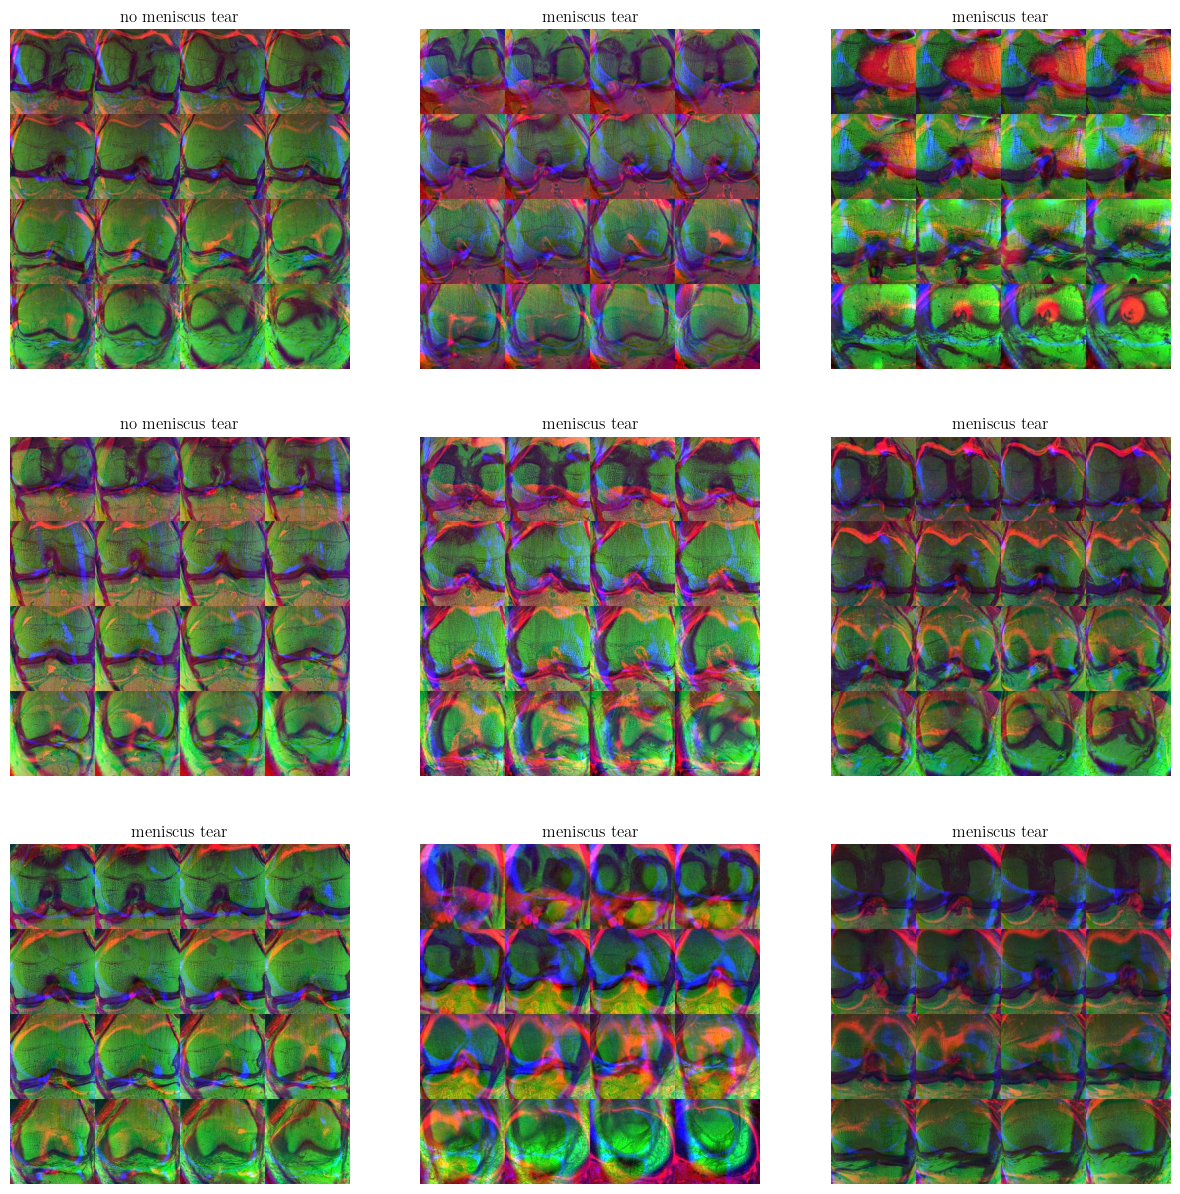

In [272]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    # plt.xlabel(
    plt.axis("off")
    
    
    

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

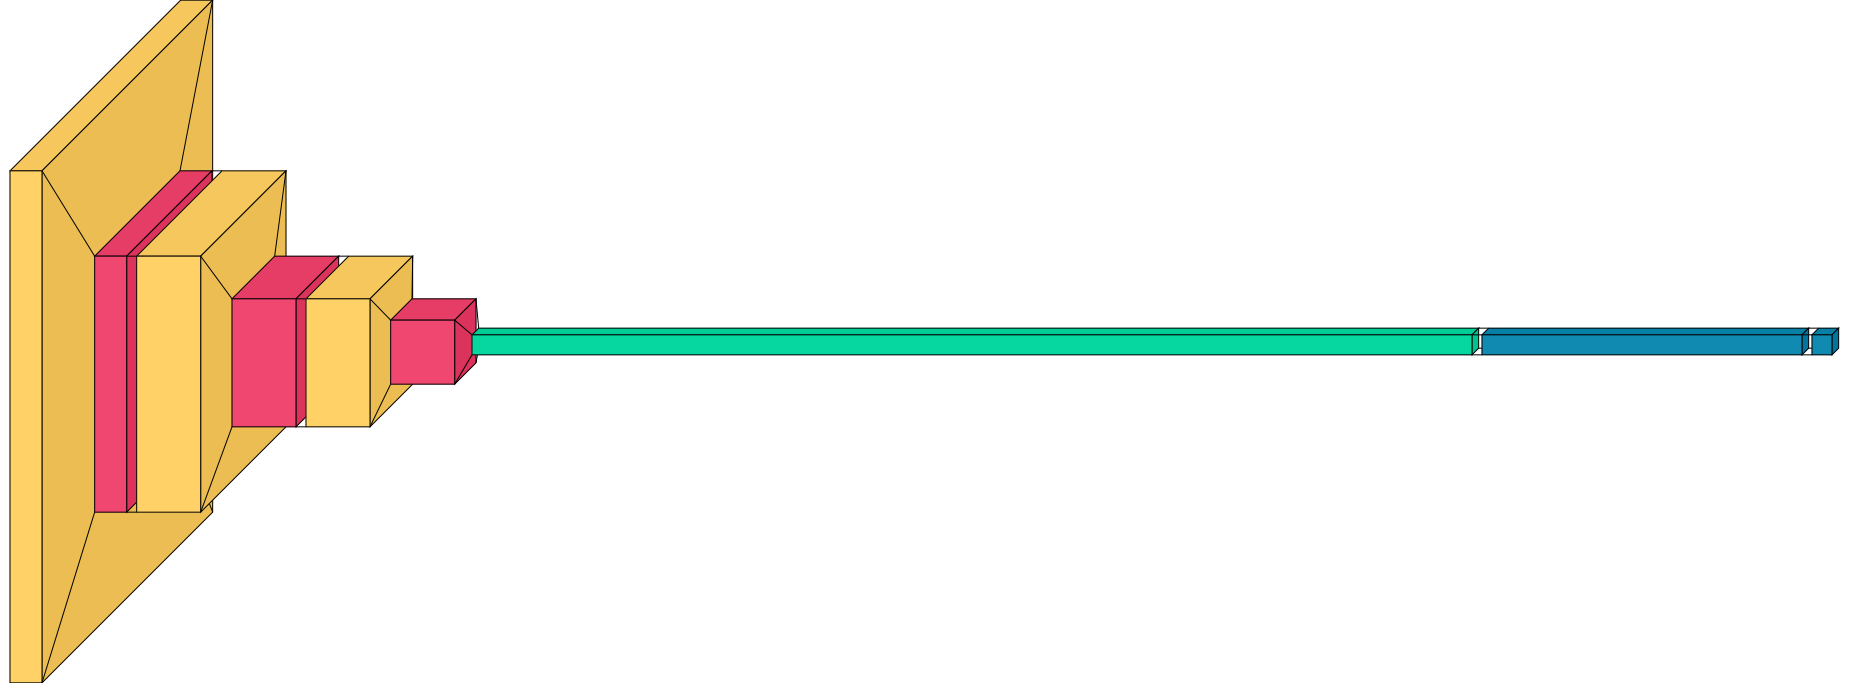

In [20]:
from tensorflow.keras.models import Sequential #functional API exists aswell for fancier stuff
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras
from PIL import ImageFont
from tensorflow.keras.regularizers import l2
# font = PIL.ImageFont.load_default()

model = Sequential()

# Convolutional layers
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(512, 512, 3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))  # Added another Conv2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for Dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(320, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))# Single output neuron for binary classification

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience =5,
                               verbose=1,
                               restore_best_weights = True)
# model = Sequential([
#   data_augmentation,

#   # layers.Conv2D(32, 2, padding='same', activation='relu', input_shape=(img_height,img_width,3) ),
#   # layers.BatchNormalization(),
#   # layers.MaxPooling2D(),
    
# #   layers.Conv2D(32, 3, padding='same', activation='relu'),
# #   layers.BatchNormalization(),
# #   layers.MaxPooling2D(),
    
# #   layers.Conv2D(64, 3, padding='same', activation='relu'),
# #   layers.BatchNormalization(),
# #   layers.MaxPooling2D(),
    
#   layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 1536, 3)),
#   layers.MaxPooling2D(pool_size=(2, 2)),

#   layers.Conv2D(64, (3, 3), activation='relu'),
#   layers.MaxPooling2D(pool_size=(2, 2)),

#   # Flatten the output for Dense layers
#   layers.Flatten(),

#   # Dense layers
#   layers.Dense(128, activation='relu'),
#   layers.Dropout(0.5),  # Dropout for regularization
#   layers.Dense(1, activation='sigmoid')
    
    
    
#   # layers.Dense(64, activation='relu'),
#   # layers.Dropout(0.3),
    
#   # layers.Conv2D(256, 3, padding='same', activation='relu'),
#   # layers.BatchNormalization(),
#   # layers.MaxPooling2D(),

#   # layers.Conv2D(32, 3, padding='same', activation='relu'),
#   # layers.BatchNormalization(),
#   # layers.MaxPooling2D(),
 
# #   layers.Flatten(), #more precise
# #   # layers.GlobalAveragePooling2D(), ###better for less detailed images (when general trends are visible easily)


# #   layers.Dense(128, activation='relu'),
# #   layers.Dropout(0.3),
    
# #   layers.Dense(1, activation='sigmoid') #if using binary cross entropy
#   # layers.Dense(nClasses, name="outputs") 
# ])

# model.add(Dense(1, activation='sigmoid')) #for binary classification use this line


# font = "arial.ttf"  # You can use a default font or provide the correct font path
from PIL import ImageFont

visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=1000)
# tf.keras.utils.plot_model(model, to_file='tf img classification ex model.svg', show_shapes=True)

In [21]:



#########scheduled learning rate (variable) ##########

# def lr_scheduler(epoch, lr):
#     learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]  # Add more learning rates to test
#     new_lr = learning_rates[epoch // 5] if epoch < 20 else lr
#     return new_lr

# num_epochs = 20  # Set your desired number of epochs
# # Create an array of epochs
# epochs = np.arange(0, num_epochs)

# # Calculate the learning rates for each epoch
# learning_rates = [lr_scheduler(epoch, 0.001) for epoch in epochs]

# # Plot the scheduled learning rates
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, learning_rates, marker='o', linestyle='-', color='b')
# plt.title('Scheduled Learning Rate vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Learning Rate')
# plt.grid(True)
# plt.show()
# lr_callback = LearningRateScheduler(lr_scheduler)
# optimizer = Adam()
# # Compile the model with the Adam optimizer
# model.compile(optimizer=optimizer,
#               # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               loss = tf.keras.losses.BinaryCrossentropy(), #for binary classification
#               metrics=['accuracy'])



##########default adam optimizer######## default learning rate

# model.compile(optimizer='adadelta',
#               # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #for multi class with int labels
#               loss = tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])


# ######### manual learning rate##########
from tensorflow.keras.optimizers import Adam


custom_learning_rate = 0.0001 # Set your desired learning rate
optimizer = Adam(learning_rate=custom_learning_rate)
# optimizer = tf.keras.optimizers.experimental.Adadelta
model.compile(optimizer=optimizer,
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = tf.keras.losses.BinaryCrossentropy(), #for binary classification
              metrics=['accuracy'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 64)       

In [22]:
#use some of the training data as test data: 
print("Len of train data before splitting:", int(len(train_ds)))
train_size = int(len(train_ds)*.8) #70% for training
test_size = int(len(train_ds)*.2) #10% for testing might need to add some batches (+...) because int will round down

print("train_size",train_size)
print("test_size", test_size)

# train_ds_final = train_ds.take(train_size)
# test_ds_final = train_ds.skip(train_size-1).take(test_size) #skips everything already used and taking the rest

train_ds_final = train_ds.take(train_size)
test_ds_final = train_ds.skip(train_size)
print("Len of created train_ds_final",len(train_ds_final))
print("Len of created test_ds",len(test_ds_final))

Len of train data before splitting: 25
train_size 20
test_size 5
Len of created train_ds_final 20
Len of created test_ds 5


In [23]:
epochs = 30
history = model.fit(
  train_ds_final,
  validation_data=val_ds,
  callbacks=[early_stopping],
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 108s 5s/step - loss: 5.5933 - accuracy: 0.4945 - val_loss: 3.6883 - val_accuracy: 0.5048
Epoch 2/30
20/20 [==============================] - 101s 5s/step - loss: 2.8960 - accuracy: 0.4945 - val_loss: 2.2673 - val_accuracy: 0.4952
Epoch 3/30
20/20 [==============================] - 105s 5s/step - loss: 1.9742 - accuracy: 0.5638 - val_loss: 1.7711 - val_accuracy: 0.4952
Epoch 4/30
20/20 [==============================] - 96s 5s/step - loss: 1.6074 - accuracy: 0.5323 - val_loss: 1.5120 - val_accuracy: 0.5048
Epoch 5/30
20/20 [==============================] - 99s 5s/step - loss: 1.3908 - accuracy: 0.5562 - val_loss: 1.3331 - val_accuracy: 0.5333
Epoch 6/30
20/20 [==============================] - 104s 5s/step - loss: 1.2254 - accuracy: 0.6078 - val_loss: 1.2204 - val_accuracy: 0.4952
Epoch 7/30
20/20 [==============================] - 106s 5s/step - loss: 1.1045 - accuracy: 0.6504 - val_loss: 1.1236 - val_accuracy: 0.4667
Epoch 8/30
20/2

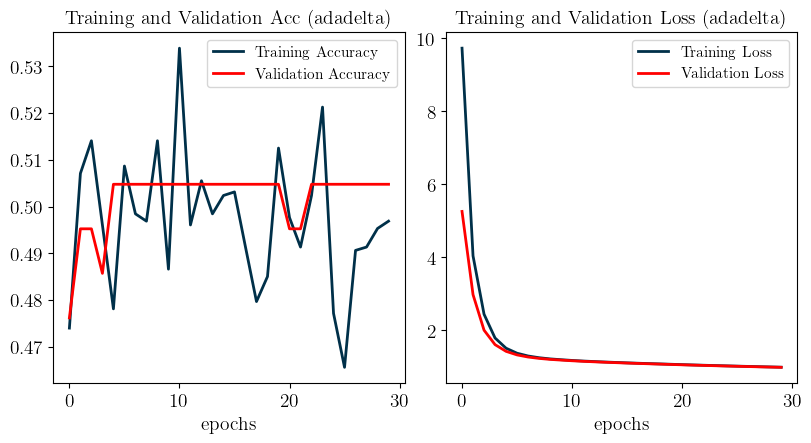

In [18]:
from matplotlib import rc
usetex = True
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8),constrained_layout=True)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth = 2, color='#003049')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth = 2, color = 'r')
plt.legend(loc='lower right')
plt.title('Training and Validation Acc (adadelta)', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("epochs", fontsize = 14)
plt.legend(prop={'size': 11})
ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
# plt.axis('scaled')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth = 2, color='#003049')
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth = 2, color = 'r')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (adadelta)', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("epochs", fontsize = 14)
plt.legend(prop={'size': 11})
ax = plt.gca()
ax.set_box_aspect(1)
# ax.set_aspect('equal', adjustable='box')
# plt.axis('scaled')
# plt.tight_layout()
plt.savefig("TrainingAcc and Loss.png", dpi = 500)
plt.show()

In [323]:
# model = tf.keras.models.load_model('models/axial-coronal-sagittal-classifier1.h5')

#for multi class model this converts raw model outputs to probabilities of each class, 
#do NOT use when using sigmoid activation in model

# probability_model = tf.keras.Sequential([model, 
                                       # tf.keras.layers.Softmax()]) ONLY FOR MULTICLASS 






1/1 [==============================] - 0s 105ms/step


2023-12-01 20:20:28.580192: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Index out of range using input dim 1; input has only 1 dims


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

<font size=5> Evaluate on test data

1/1 [==============================] - 1s 1s/step
class [1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1]
pred int: [1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 0. 1.]
pred: [0.75 0.97 0.77 0.02 0.37 0.03 0.04 0.04 0.83 0.51 0.36 0.03 0.84 0.08
 0.03 0.01 0.05 0.02 0.05 0.08 0.04 0.16 0.06 0.86 0.68 0.02 0.16 0.64
 0.78 0.57 0.06 0.52]
1/1 [==============================] - 1s 1s/step
class [0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0]
pred int: [0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0.]
pred: [0.09 0.78 0.81 0.34 0.24 0.53 0.12 0.85 0.12 0.94 0.75 0.36 0.86 0.85
 0.89 0.19 0.21 0.09 0.88 0.86 0.28 0.04 0.19 0.02 0.81 0.02 0.07 0.56
 0.01 0.44 0.86 0.17]
1/1 [==============================] - 1s 1s/step
class [1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1]
pred int: [1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.

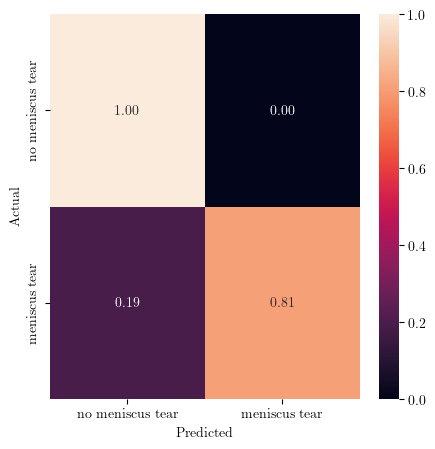

In [398]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC, SparseCategoricalAccuracy, CategoricalAccuracy, Accuracy
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import brier_score_loss


pre = Precision()
re = Recall()
acc = BinaryAccuracy() #for binary model (2 classes)
# acc = Accuracy() #for multi class model
AUC = AUC()


test_labels_total = np.array([])
model_predictions_total = np.array([])
for batch in iter(test_ds_final): 
    X, y = batch #X are images, y are labels for the batch
    y = np.array(y)
    test_labels_total = np.concatenate((test_labels_total.astype(int), y.astype(int)))
    
    yhat = model.predict(X)
    # yhat = np.argmax(yhat, axis=1) #if not using sigmoid on last dense layer and using softmax instead
    model_predictions_total = np.concatenate((model_predictions_total.astype(int),np.round(yhat.flatten()).astype(int)))
    print("class",y)
    print("pred int:", np.array2string(np.round(yhat.flatten())))
    print("pred:",np.array2string(yhat.flatten(), precision=2))
    # plt.imshow(X[0])
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    AUC.update_state(y, yhat)
    
# test_labels_total = np.array(test_labels_total)
# model_predictions_total = np.array(model_predictions_total)
    
print("TEST DATASET Precision: {:.3f}, Recall: {:.3f}, Accuracy: {:.3f}, AUC: {:.3f}".format(pre.result().numpy(), re.result().numpy(), acc.result().numpy(), AUC.result().numpy()))
print("matthews corr-coef", metrics.matthews_corrcoef(test_labels_total,model_predictions_total))
print(metrics.classification_report(test_labels_total,model_predictions_total, target_names=class_names))
# Calculate Brier score
brier = brier_score_loss(test_labels_total, model_predictions_total)
print("Brier Score:", brier)

#generate confusion matrix of entire test classifical 
cm = metrics.confusion_matrix(test_labels_total,model_predictions_total )
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #can get rid of this line to un-normalize and have counts instead of probability
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



#on validation dataset




    




1/1 [==============================] - 0s 326ms/step
VALIDATION DATASET Precision: 0.720, Recall: 0.676, Accuracy: 0.707, AUC: 0.797
matthews corr-coef 0.028312161574709078
                  precision    recall  f1-score   support

no meniscus tear       0.52      0.53      0.52        53
   meniscus tear       0.51      0.50      0.50        52

        accuracy                           0.51       105
       macro avg       0.51      0.51      0.51       105
    weighted avg       0.51      0.51      0.51       105

Brier Score: 0.4857142857142857


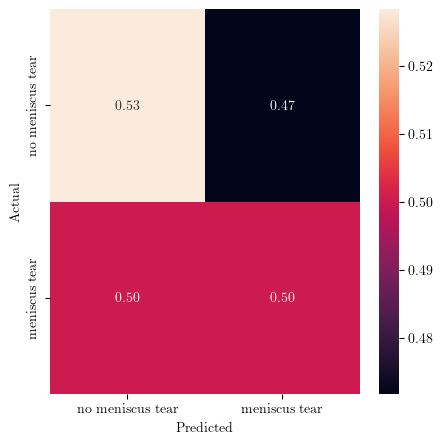

In [418]:
#on validation dataset
model_pred_total_val = np.array([])
for batch in iter(val_ds):
    X, y = batch #X are images, y are labels for the batch
    y = np.array(y)
    # test_labels_total = np.concatenate((test_labels_total.astype(int), y.astype(int)))
    
    yhat = model.predict(X)
    model_pred_total_val = np.concatenate((model_pred_total_val.astype(int),np.round(yhat.flatten()).astype(int)))
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    AUC.update_state(y, yhat)
    
    
print("VALIDATION DATASET Precision: {:.3f}, Recall: {:.3f}, Accuracy: {:.3f}, AUC: {:.3f}".format(pre.result().numpy(), re.result().numpy(), acc.result().numpy(), AUC.result().numpy()))
print("matthews corr-coef", metrics.matthews_corrcoef(valid_labels,model_pred_total_val))
print(metrics.classification_report(valid_labels,model_pred_total_val, target_names=class_names))
# Calculate Brier score
brier = brier_score_loss(valid_labels, model_pred_total_val)
print("Brier Score:", brier)

#generate confusion matrix of entire test classifical 
cm = metrics.confusion_matrix(valid_labels,model_pred_total_val )
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #can get rid of this line to un-normalize and have counts instead of probability
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

1/1 [==============================] - 0s 78ms/step
0.059008133
1/1 [==============================] - 0s 62ms/step
0.06932292
1/1 [==============================] - 0s 66ms/step
0.26405394
1/1 [==============================] - 0s 67ms/step
0.06600058
1/1 [==============================] - 0s 63ms/step
0.12566157
1/1 [==============================] - 0s 64ms/step
0.57971877
1/1 [==============================] - 0s 64ms/step
0.65791357
1/1 [==============================] - 0s 62ms/step
0.014995156
1/1 [==============================] - 0s 62ms/step
0.13502201


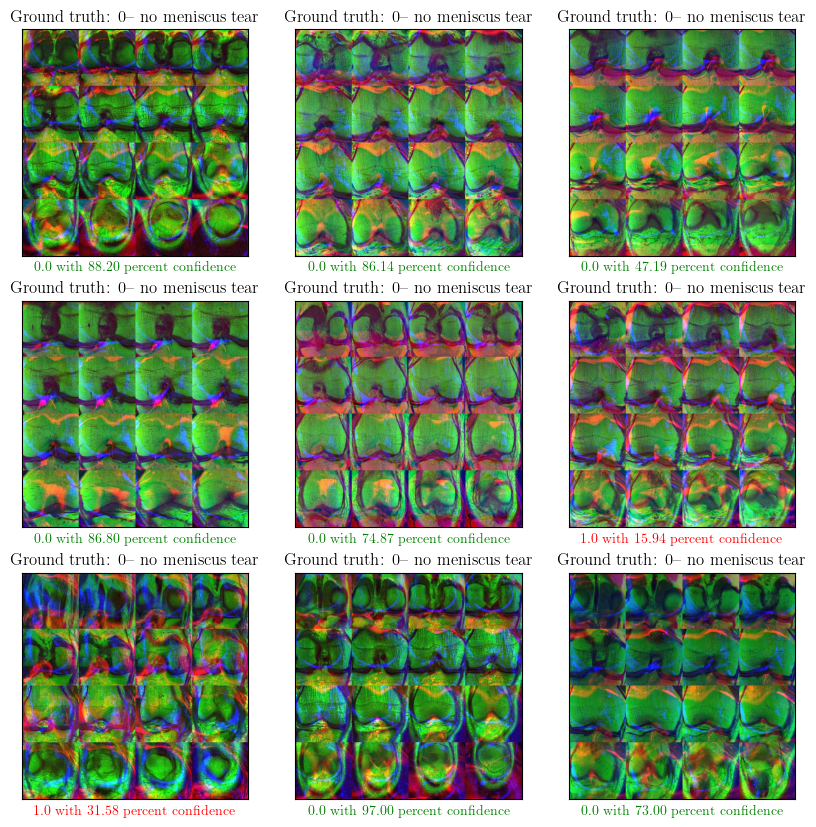

In [408]:
from sklearn.metrics import brier_score_loss
def get_confidence(prediction):
    return abs(prediction - 0.5) * 2 * 100
pre = Precision()
re = Recall()
acc = BinaryAccuracy() #for binary model (2 classes)
# acc = Accuracy() #for multi class model
AUC = AUC()



#plot some example images and classifications from a batch
test_image_batch, test_labels_batch = next(iter(test_ds_final))
test_labels_batch = np.array(test_labels_batch)
prediction = probability_model.predict(test_image_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_batch[i].numpy())
    y_true = test_image_batch[i]
    img_array = tf.keras.utils.img_to_array(test_image_batch[i])
    img_array = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array)# Create a batch
    confidence = get_confidence(prediction.flatten()[0])
    print(prediction.flatten()[0])
    plt.title("Ground truth: " + str(test_labels_batch[i])+ "-- " + str(class_names[test_labels_batch[i]]))
    if test_labels_batch[i] == np.round(prediction):
        plt.xlabel(str(np.round(prediction.flatten()[0])) + " with {:.2f} percent confidence".format(confidence), color = 'g')
    else:
        plt.xlabel(str(np.round(prediction.flatten()[0])) + " with {:.2f} percent confidence".format(confidence), color = 'r')
    

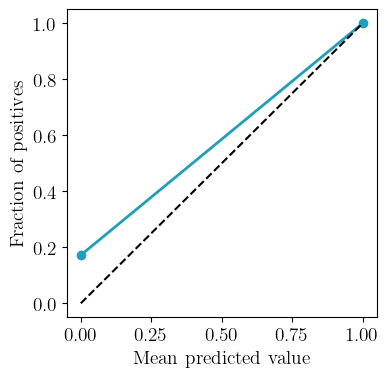

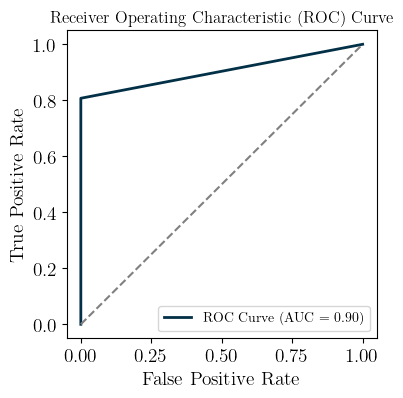

In [407]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score


# Assuming 'y_true' contains true labels and 'y_prob' contains predicted probabilities
# Replace 'y_true' and 'y_prob' with your actual data
# y_true = [0, 1, 1, 0, 1]
# y_prob = [0.1, 0.9, 0.8, 0.2, 0.7]

fraction_of_positives, mean_predicted_value = calibration_curve(test_labels_total, model_predictions_total, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.figure(figsize=(4, 4))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2, color = '#219ebc')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Ideal curve (perfect calibration)
plt.xlabel('Mean predicted value', fontsize = 14)
plt.ylabel('Fraction of positives', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
# plt.title('Calibration Curve')
plt.show()




# Assuming y_true and y_pred are your true labels and predicted probabilities, respectively

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels_total, model_predictions_total)
roc_auc = roc_auc_score(test_labels_total, model_predictions_total)
    
    
# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='#023047', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend()
plt.show()

NameError: name 'array' is not defined

In [419]:
model.save(os.path.join('models','binary_meniscus_bal_data_adam_lr_0.0005.h5'))

/Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/ImageClassification/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [420]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('binary_meniscus_bal_data_adam_lr_0.0005', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/r0/gj4zfnpx5hj2wjmlwg285k4w0000gn/T/tmp7bi0he5v/assets


INFO:tensorflow:Assets written to: /var/folders/r0/gj4zfnpx5hj2wjmlwg285k4w0000gn/T/tmp7bi0he5v/assets
2023-12-01 21:55:39.078767: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-01 21:55:39.078794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-01 21:55:39.091299: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r0/gj4zfnpx5hj2wjmlwg285k4w0000gn/T/tmp7bi0he5v
2023-12-01 21:55:39.095591: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-01 21:55:39.095605: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/r0/gj4zfnpx5hj2wjmlwg285k4w0000gn/T/tmp7bi0he5v
2023-12-01 21:55:39.108420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-01 21:55:39.110617: I tensorflow/cc/saved_model/load

In [186]:
 def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]

AttributeError: 'int' object has no attribute 'astype'